In [75]:
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns=None
pd.options.display.max_rows=None

# load train and test data sets
X = pd.read_csv('./input/train.csv')
X_test = pd.read_csv('./input/test.csv')

# remove data with missing target values, separate targets from predictors
X.dropna(subset=['SalePrice'],inplace=True)
y = X.SalePrice
X.drop('SalePrice',axis=1,inplace=True)

exclude_cols=['MiscFeature','PoolQC','Alley']
X.drop(exclude_cols,axis=1,inplace=True)
X_test.drop(exclude_cols,axis=1,inplace=True)

# list numeric and categorical columns
numerical_cols = X.select_dtypes(exclude='object').columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

X_train, X_valid, y_train, y_valid = train_test_split(X,y,train_size=0.8,test_size=0.2,random_state=0)

# categorical columns safe for encoding
good_cat_columns = [col for col in categorical_cols if set(X_train[col].unique())==set(X_valid[col].unique())]
bad_cat_columns = list(set(categorical_cols)-set(good_cat_columns))

X_train.drop(bad_cat_columns, axis=1, inplace=True)
X_valid.drop(bad_cat_columns, axis=1, inplace=True)
X_test.drop(bad_cat_columns, axis=1, inplace=True)

# low and high cardinality categorical columns
low_cardinality_cols = [col for col in good_cat_columns if X[col].nunique() < 10]
high_cardinality_cols = list(set(good_cat_columns)-set(low_cardinality_cols))

In [76]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

def get_scores(n_estimators):
    # preprocessing of numerical columns
    numerical_transformer = SimpleImputer(strategy='median')

    # preprocessing of low cardinality columns
    OH_transformer = Pipeline(steps=[
        ('imputation',SimpleImputer(strategy='constant')),
        ('one_hot_encoding',OneHotEncoder(handle_unknown='ignore'))
    ])

    # preprocessing of high_cardinality columns
    Label_transformer = Pipeline(steps=[
        ('imputation',SimpleImputer(strategy='constant')),
        ('label_encoding',LabelEncoder())
    ])

    # bundle preprocessing of numerical and categorical columns
    preprocessor = ColumnTransformer(transformers=[
        ('num',numerical_transformer,numerical_cols),
        ('oh',OH_transformer,low_cardinality_cols),
        ('lbl',Label_transformer,high_cardinality_cols)
    ])

    # define model
    model = XGBRegressor(n_estimators=n_estimators, learning_rate=0.05, random_state=0, 
                         subsample=0.8, objective='reg:squarederror', max_depth=6)

    # bundle preprocessing and modeling code
    clf = Pipeline(steps=[
        ('preprocessing',preprocessor),
        ('model',model)
    ])

    scores = -1 * cross_val_score(clf,X,y,cv=5,scoring='neg_mean_absolute_error')
    print(scores)
    return scores.mean()

In [77]:
number_of_estimators=[50, 100, 150, 200, 250, 300, 350, 400, 450, ]
# number_of_estimators=[250, 300, 350, 400, 450, 500, 550, 600]
results = {n:get_scores(n) for n in number_of_estimators}

[22210.85621789 20910.033872   23910.72661601 18134.7287698
 23506.29890839]
[16335.98959225 16351.20466342 16855.79324968 14248.44741278
 17242.75334439]
[16017.04947025 16306.41721961 16684.63720034 14078.85429152
 16563.99446169]
[15909.63944777 16256.22056935 16645.69396137 13993.94564694
 16354.80233305]
[15846.37363549 16268.79612586 16738.59194403 13958.07780394
 16294.53042059]
[15834.92826948 16212.51513003 16764.33682042 13900.24549176
 16304.24261558]
[15879.27828018 16229.02968482 16820.85625803 13879.22788688
 16265.11964897]
[15886.27030715 16223.20608144 16836.19214202 13864.19075075
 16248.34701413]
[15897.68899829 16219.02173855 16881.38619702 13858.51598619
 16267.41834332]


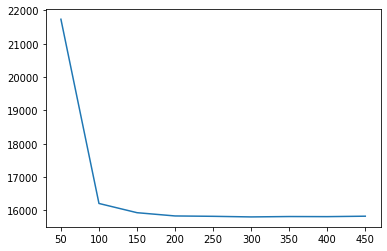

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(list(results.keys()), list(results.values()))
plt.show()

In [79]:
for k in results:
    print(k,results[k])

50 21734.52887681935
100 16206.83765250428
150 15930.190528681507
200 15832.060391695204
250 15821.273985980308
300 15803.253665453765
350 15814.70235177654
400 15811.641259096747
450 15824.806252675515


In [ ]:
clf.fit(X_train,y_train)

In [4]:
preds = clf.predict(X_valid)

from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_valid,preds)

16826.433473351884

In [5]:
# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index+1461,
                       'SalePrice': preds})
output.to_csv('submission.csv', index=False)

ValueError: arrays must all be same length

In [ ]:
[(col,X[col].isnull().sum()) for col in X.columns if X[col].isnull().any()]

In [80]:
X[numerical_cols].head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008


In [81]:
X[numerical_cols].describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000
